<a href="https://colab.research.google.com/github/SergeiVKalinin/MSE_Fall2023/blob/main/Module%207/23_AE_and_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tutorial notebook for the Fall 2023 Course "Machine Learning for Materials Science", University of Tennessee Knoxville, Department of Materials Science and Engineering.

Based on the
- Rowel Atienza book: https://subscription.packtpub.com/book/programming/9781838821654/pref
and
- ChatGPT for code adjustment

# DCNN Classifiers

Let's explore more the Keras classifiers for MNIST data written using different NN architectures.

## MNIST data

11490434/11490434 [==============================] - 0s 0us/step
Train labels:  {0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}
Test labels:  {0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}


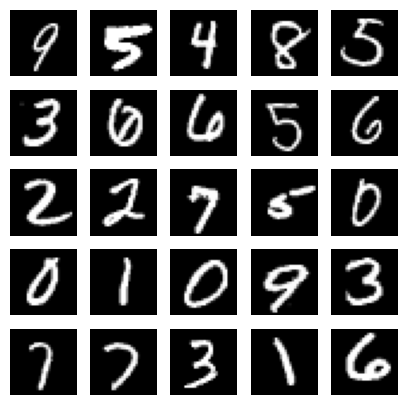

In [1]:
import numpy as np
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

# load dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# count the number of unique train labels
unique, counts = np.unique(y_train, return_counts=True)
print("Train labels: ", dict(zip(unique, counts)))

# count the number of unique test labels
unique, counts = np.unique(y_test, return_counts=True)
print("Test labels: ", dict(zip(unique, counts)))

# sample 25 mnist digits from train dataset
indexes = np.random.randint(0, x_train.shape[0], size=25)
images = x_train[indexes]
labels = y_train[indexes]

# plot the 25 mnist digits
plt.figure(figsize=(5,5))
for i in range(len(indexes)):
    plt.subplot(5, 5, i + 1)
    image = images[i]
    plt.imshow(image, cmap='gray')
    plt.axis('off')

plt.savefig("mnist-samples.png")
plt.show()
plt.close('all')

In [2]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.datasets import mnist

# load mnist dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# compute the number of labels
num_labels = len(np.unique(y_train))

# convert to one-hot vector
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# image dimensions (assumed square)
image_size = x_train.shape[1]
input_size = image_size * image_size

# resize and normalize
x_train = np.reshape(x_train, [-1, input_size])
x_train = x_train.astype('float32') / 255
x_test = np.reshape(x_test, [-1, input_size])
x_test = x_test.astype('float32') / 255

## MLP on MNIST

In [3]:
# network parameters
batch_size = 128
hidden_units = 256
dropout = 0.45

# model is a 3-layer MLP with ReLU and dropout after each layer
model = Sequential()
model.add(Dense(hidden_units, input_dim=input_size))
model.add(Activation('relu'))
model.add(Dropout(dropout))
model.add(Dense(hidden_units))
model.add(Activation('relu'))
model.add(Dropout(dropout))
model.add(Dense(num_labels))
# this is the output for one-hot vector
model.add(Activation('softmax'))
model.summary()
plot_model(model, to_file='mlp-mnist.png', show_shapes=True)

# loss function for one-hot vector
# use of adam optimizer
# accuracy is good metric for classification tasks
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# train the network
model.fit(x_train, y_train, epochs=20, batch_size=batch_size)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               200960    
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                2

In [4]:
# validate the model on test dataset to determine generalization
_, acc = model.evaluate(x_test,
                        y_test,
                        batch_size=batch_size,
                        verbose=0)
print("\nTest accuracy: %.1f%%" % (100.0 * acc))


Test accuracy: 98.2%


## DCNN on MNIST

In [5]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.datasets import mnist

# load mnist dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# compute the number of labels
num_labels = len(np.unique(y_train))

# convert to one-hot vector
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# input image dimensions
image_size = x_train.shape[1]

# resize and normalize
x_train = np.reshape(x_train,[-1, image_size, image_size, 1])
x_test = np.reshape(x_test,[-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
# image is processed as is (square grayscale)
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
pool_size = 2
filters = 64
dropout = 0.2

# model is a stack of CNN-ReLU-MaxPooling
model = Sequential()
model.add(Conv2D(filters=filters,
                 kernel_size=kernel_size,
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size))
model.add(Conv2D(filters=filters,
                 kernel_size=kernel_size,
                 activation='relu'))
model.add(MaxPooling2D(pool_size))
model.add(Conv2D(filters=filters,
                 kernel_size=kernel_size,
                 activation='relu'))
model.add(Flatten())
# dropout added as regularizer
model.add(Dropout(dropout))
# output layer is 10-dim one-hot vector
model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.summary()
plot_model(model, to_file='cnn-mnist.png', show_shapes=True)

# loss function for one-hot vector
# use of adam optimizer
# accuracy is good metric for classification tasks
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# train the network
model.fit(x_train, y_train, epochs=10, batch_size=batch_size)

_, acc = model.evaluate(x_test,
                        y_test,
                        batch_size=batch_size,
                   verbose=0)
print("\nTest accuracy: %.1f%%" % (100.0 * acc))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 576)              

## RNN on MNIST

In [6]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, SimpleRNN
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.datasets import mnist

# load mnist dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# compute the number of labels
num_labels = len(np.unique(y_train))

# convert to one-hot vector
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# resize and normalize
image_size = x_train.shape[1]
x_train = np.reshape(x_train,[-1, image_size, image_size])
x_test = np.reshape(x_test,[-1, image_size, image_size])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (image_size, image_size)
batch_size = 128
units = 256
dropout = 0.2

# model is RNN with 256 units, input is 28-dim vector 28 timesteps
model = Sequential()
model.add(SimpleRNN(units=units,
                    dropout=dropout,
                    input_shape=input_shape))
model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.summary()
plot_model(model, to_file='rnn-mnist.png', show_shapes=True)

# loss function for one-hot vector
# use of sgd optimizer
# accuracy is good metric for classification tasks
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
# train the network
model.fit(x_train, y_train, epochs=20, batch_size=batch_size)

_, acc = model.evaluate(x_test,
                        y_test,
                        batch_size=batch_size,
                        verbose=0)
print("\nTest accuracy: %.1f%%" % (100.0 * acc))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 256)               72960     
                                                                 
 dense_4 (Dense)             (None, 10)                2570      
                                                                 
 activation_4 (Activation)   (None, 10)                0         
                                                                 
Total params: 75530 (295.04 KB)
Trainable params: 75530 (295.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
469/469 [==============================] - 8s 14ms/step - loss: 0.7575 - accuracy: 0.7816
Epoch 2/20
469/469 [==============================] - 7s 14ms/step - loss: 0.3346 - accuracy: 0.9033
Epoch 3/20
469/469 [==============================] - 6s 14ms/step - loss: 0.2

# Simple Autoencoder

In [7]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt

# load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()


x_train = x_train[0::10]
x_test = x_test[0::10]
y_test = y_test[0::10]
'''

x_train = x_train[y_train == 7]
x_test = x_test[y_test == 7]
y_test = y_test[y_test == 7]
'''

# reshape to (28, 28, 1) and normalize input images
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 2

# encoder/decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

# stack of Conv2D(32)-Conv2D(64)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

# shape info needed to build decoder model
# so we don't do hand computation
# the input to the decoder's first
# Conv2DTranspose will have this shape
# shape is (7, 7, 64) which is processed by
# the decoder back to (28, 28, 1)

shape = K.int_shape(x)
# generate latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)
# instantiate encoder model
encoder = Model(inputs,
                latent,
                name='encoder')
encoder.summary()
plot_model(encoder,
           to_file='encoder.png',
           show_shapes=True)

# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# use the shape (7, 7, 64) that was earlier saved
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)
# stack of Conv2DTranspose(64)-Conv2DTranspose(32)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
# reconstruct the input
outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='decoder.png', show_shapes=True)

# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs,
                    decoder(encoder(inputs)),
                    name='autoencoder')
autoencoder.summary()
plot_model(autoencoder,
           to_file='autoencoder.png',
           show_shapes=True)

# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')

# train the autoencoder
autoencoder.fit(x_train,
                x_train,
                validation_data=(x_test, x_test),
                epochs=10,
                batch_size=batch_size)

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 flatten_1 (Flatten)         (None, 3136)              0         
                                                                 
 latent_vector (Dense)       (None, 2)                 6274      
                                                                 
Total params: 25090 (98.01 KB)
Trainable params: 25090 (98.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "decoder"
______

The original data

(4, 4, 28, 28)


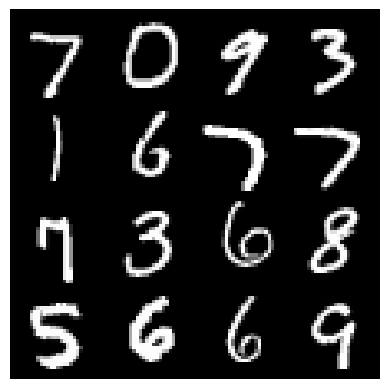

In [8]:
imgs = x_test[:16]
imgs = imgs.reshape((4, 4, image_size, image_size))
print(imgs.shape)
imgs = np.vstack([np.hstack(i) for i in imgs])

plt.figure()
plt.axis('off')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('input.png')
plt.show()

The decoded data

32/32 [==============================] - 0s 2ms/step
(4, 4, 28, 28)


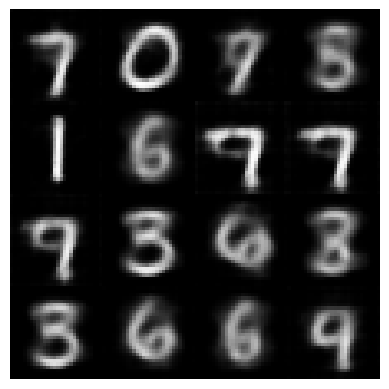

In [9]:
# predict the autoencoder output from test data
x_decoded = autoencoder.predict(x_test)

# display the 1st 8 test input and decoded images
imgs = x_decoded[:16]
imgs = imgs.reshape((4, 4, image_size, image_size))
print(imgs.shape)
imgs = np.vstack([np.hstack(i) for i in imgs])

plt.figure()
plt.axis('off')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('decoded.png')
plt.show()

## Latent distribution

In [10]:
import matplotlib.pyplot as plt

def plot_latent_distribution(data, labels, encoder):
    """
    Plots the latent distribution of the data using a 2D latent space.

    Parameters:
    - data: The input data to encode and plot.
    - encoder: The encoder model with a `predict` method that encodes data into a 2D latent space.
    """

    # Use the encoder to transform the data into the latent space
    latent_variables = encoder.predict(data)

    # Check if the latent space is 2D
    if latent_variables.shape[1] != 2:
        raise ValueError("The latent space is not 2D.")

    # Plotting the latent space distribution
    plt.figure(figsize=(8, 8))
    plt.scatter(latent_variables[:, 0], latent_variables[:, 1], c = labels, alpha=0.7)
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('Latent Space Distribution')
    plt.grid(True)
    plt.show()

32/32 [==============================] - 0s 1ms/step


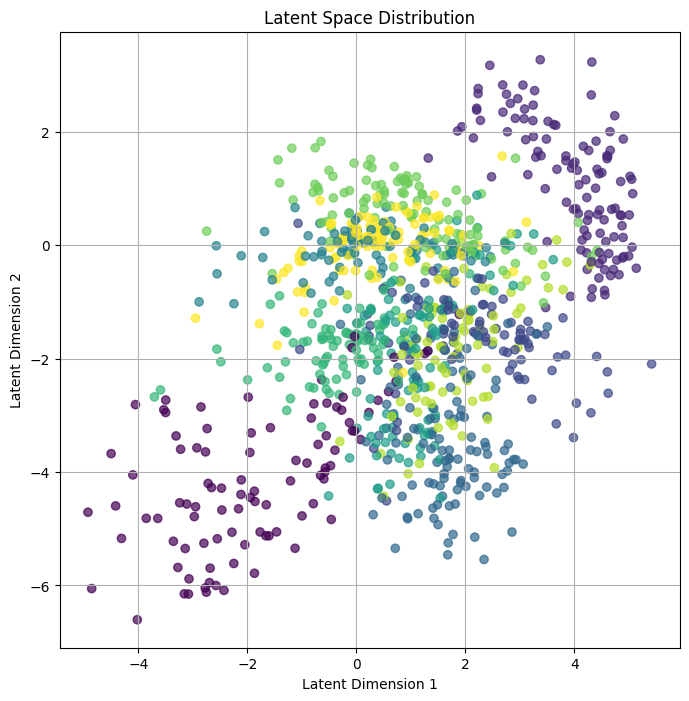

In [11]:
plot_latent_distribution(x_test, y_test, encoder)

## Latent representation

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def plot_latent_space(decoder, num_samples=10, grid_range=3, image_size=(28, 28)):
    """
    Generates a grid of images decoded from latent space points.

    Parameters:
    - decoder: The decoder model that decodes latent points into images.
    - num_samples: The number of images per dimension in the grid.
    - grid_range: The range of values in each dimension of the latent space grid.
    - image_size: A tuple (height, width) of the images.
    """

    # Linearly spaced coordinates corresponding to the 2D grid
    grid_x = np.linspace(-grid_range, grid_range, num_samples)
    grid_y = np.linspace(-grid_range, grid_range, num_samples)

    # Create a figure with subplots
    figure, axes = plt.subplots(num_samples, num_samples, figsize=(10, 10))

    # Remove inner axes numbers
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])

    # Plotting the grid
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample);
            img = x_decoded[0].reshape(image_size)  # Adjust the shape based on your data
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].axis('off')

    # Adjust the spacing between plots
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

# Usage example (assuming your decoder is named 'decoder'):
# plot_latent_space(decoder, num_samples=10, grid_range=3, image_size=(28, 28))


1/1 [==============================] - 0s 16ms/step


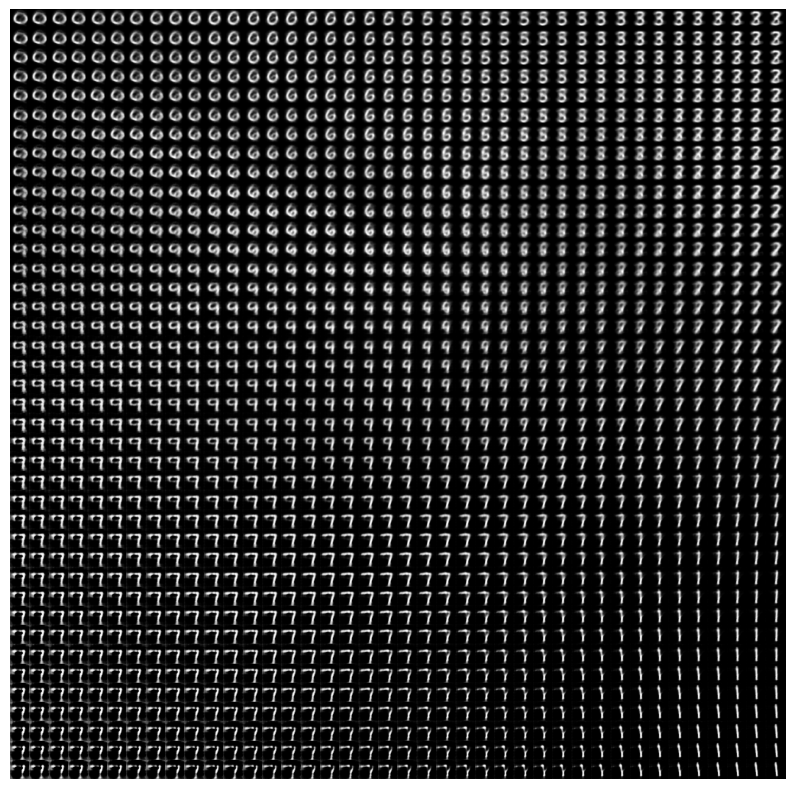

In [13]:
plot_latent_space(decoder, num_samples=40, grid_range=3)

# Autoencoders

Here, we will explore some useful autoencoder applications

## Denoising Autoencoder

In [14]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

np.random.seed(1337)

# load MNIST dataset
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train[0::10]
x_test = x_test[0::10]
y_test = y_test[0::10]

# reshape to (28, 28, 1) and normalize input images
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# generate corrupted MNIST images by adding noise with normal dist
# centered at 0.5 and std=0.5
noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
x_train_noisy = x_train + noise

noise = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_test_noisy = x_test + noise
# adding noise may exceed normalized pixel values>1.0 or <0.0
# clip pixel values >1.0 to 1.0 and <0.0 to 0.0
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

# stack of Conv2D(32)-Conv2D(64)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

# shape info needed to build decoder model so we don't do hand computation
# the input to the decoder's first Conv2DTranspose will have this shape
# shape is (7, 7, 64) which can be processed by the decoder back to (28, 28, 1)
shape = K.int_shape(x)

# generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# instantiate encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# use the shape (7, 7, 64) that was earlier saved
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)

# stack of Conv2DTranspose(64)-Conv2DTranspose(32)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

# reconstruct the denoised input
outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          padding='same',
                          activation='sigmoid',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')

# train the autoencoder
autoencoder.fit(x_train_noisy,
                x_train,
                validation_data=(x_test_noisy, x_test),
                epochs=10,
                batch_size=batch_size)




Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 32)        320       
                                                                 
 conv2d_6 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 flatten_2 (Flatten)         (None, 3136)              0         
                                                                 
 latent_vector (Dense)       (None, 16)                50192     
                                                                 
Total params: 69008 (269.56 KB)
Trainable params: 69008 (269.56 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "decoder"
____

32/32 [==============================] - 0s 2ms/step


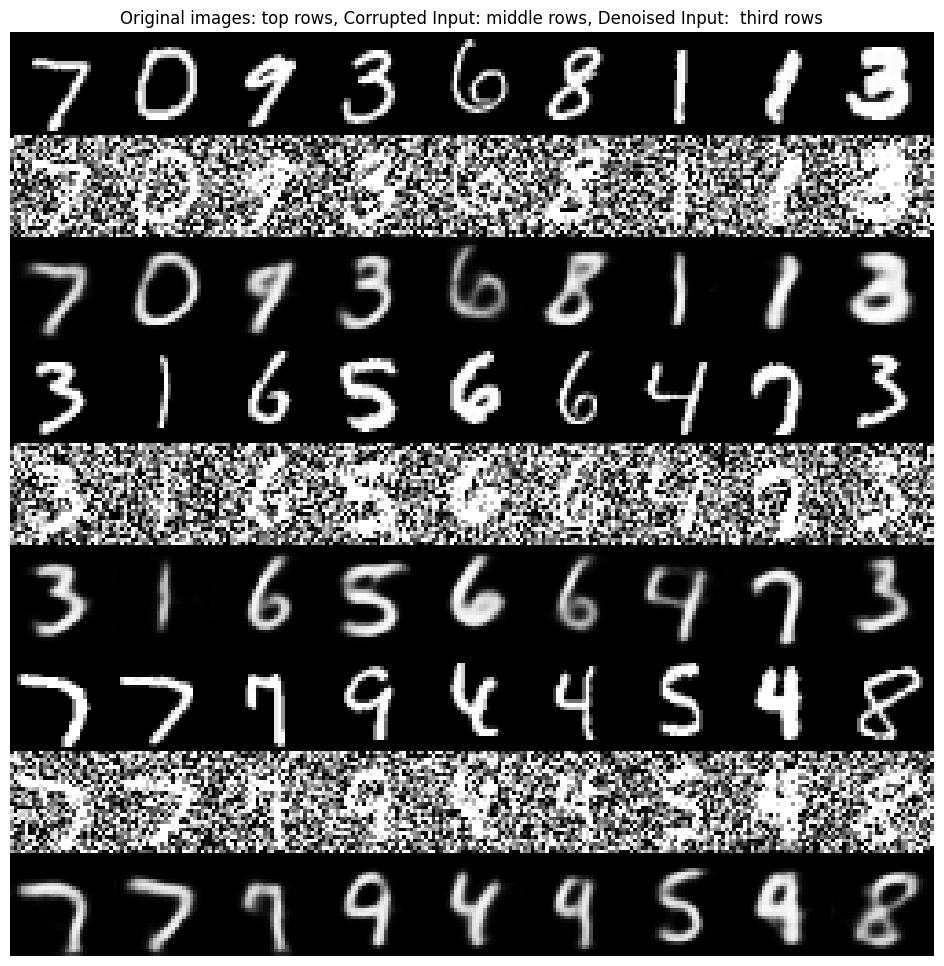

In [15]:
# predict the autoencoder output from corrupted test images
x_decoded = autoencoder.predict(x_test_noisy)

# 3 sets of images with 9 MNIST digits
# 1st rows - original images
# 2nd rows - images corrupted by noise
# 3rd rows - denoised images

rows, cols = 3, 9
num = rows * cols
imgs = np.concatenate([x_test[:num], x_test_noisy[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)

plt.figure(figsize = (12,12))
plt.axis('off')
plt.title('Original images: top rows, '
          'Corrupted Input: middle rows, '
          'Denoised Input:  third rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
Image.fromarray(imgs).save('corrupted_and_denoised.png')
plt.show()

## Colorizing Autoencoder

170498071/170498071 [==============================] - 3s 0us/step


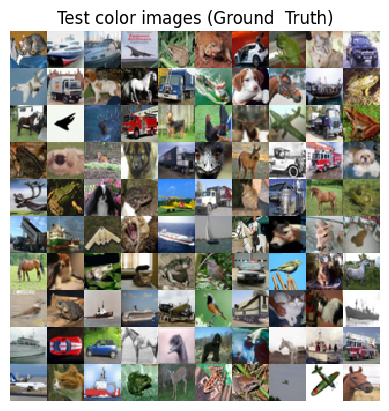

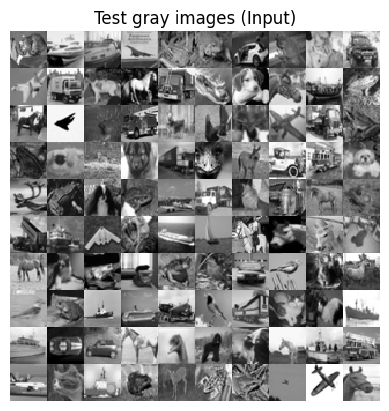

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 64)        640       
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 conv2d_9 (Conv2D)           (None, 4, 4, 256)         295168    
                                                                 
 flatten_3 (Flatten)         (None, 4096)              0         
                                                                 
 latent_vector (Dense)       (None, 256)               1048832   
                                                                 
Total params: 1418496 (5.41 MB)
Trainable params: 1418496 (

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1560/1563 [============================>.] - ETA: 0s - loss: 0.0101
Epoch 2: val_loss improved from 0.01086 to 0.00969, saving model to /content/saved_models/colorized_ae_model.002.h5
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0101 - val_loss: 0.0097 - lr: 0.0010
Epoch 3/50
1563/1563 [==============================] - ETA: 0s - loss: 0.0091
Epoch 3: val_loss improved from 0.00969 to 0.00893, saving model to /content/saved_models/colorized_ae_model.003.h5
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0091 - val_loss: 0.0089 - lr: 0.0010
Epoch 4/50
1562/1563 [============================>.] - ETA: 0s - loss: 0.0085
Epoch 4: val_loss improved from 0.00893 to 0.00818, saving model to /content/saved_models/colorized_ae_model.004.h5
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0085 - val_loss: 0.0082 - lr: 0.0010
Epoch 5/50
1562/1563 [============================>.] - ETA: 0s - loss: 0.0081
Epoch 5: val_loss did not improve 

In [16]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import os

def rgb2gray(rgb):
    """Convert from color image (RGB) to grayscale.
       Source: opencv.org
       grayscale = 0.299*red + 0.587*green + 0.114*blue
    Argument:
        rgb (tensor): rgb image
    Return:
        (tensor): grayscale image
    """
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

# load the CIFAR10 data
(x_train, _), (x_test, y_test) = cifar10.load_data()

#x_train = x_train[0::10]
#x_test = x_test[0::10]
#y_test = y_test[0::10]

# input image dimensions
# we assume data format "channels_last"
img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
channels = x_train.shape[3]

# create saved_images folder
imgs_dir = 'saved_images'
save_dir = os.path.join(os.getcwd(), imgs_dir)
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

# display the 1st 100 input images (color and gray)
imgs = x_test[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])

plt.figure()
plt.axis('off')
plt.title('Test color images (Ground  Truth)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/test_color.png' % imgs_dir)
plt.show()

# convert color train and test images to gray
x_train_gray = rgb2gray(x_train)
x_test_gray = rgb2gray(x_test)

# display grayscale version of test images
imgs = x_test_gray[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols))
imgs = np.vstack([np.hstack(i) for i in imgs])

plt.figure()
plt.axis('off')
plt.title('Test gray images (Input)')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('%s/test_gray.png' % imgs_dir)
plt.show()

# normalize output train and test color images
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# normalize input train and test grayscale images
x_train_gray = x_train_gray.astype('float32') / 255
x_test_gray = x_test_gray.astype('float32') / 255

# reshape images to row x col x channel for CNN output/validation
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)

# reshape images to row x col x channel for CNN input
x_train_gray = x_train_gray.reshape(x_train_gray.shape[0], img_rows, img_cols, 1)
x_test_gray = x_test_gray.reshape(x_test_gray.shape[0], img_rows, img_cols, 1)

# network parameters
input_shape = (img_rows, img_cols, 1)
batch_size = 32
kernel_size = 3
latent_dim = 256

# encoder/decoder number of CNN layers and filters per layer
layer_filters = [64, 128, 256]

# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

# stack of Conv2D(64)-Conv2D(128)-Conv2D(256)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

# shape info needed to build decoder model so we don't do hand computation
# the input to the decoder's first Conv2DTranspose will have this shape
# shape is (4, 4, 256) which is processed by the decoder back to (32, 32, 3)
shape = K.int_shape(x)

# generate a latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# instantiate encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# stack of Conv2DTranspose(256)-Conv2DTranspose(128)-Conv2DTranspose(64)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

outputs = Conv2DTranspose(filters=channels,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

# prepare model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'colorized_ae_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# reduce learning rate by sqrt(0.1) if the loss does not improve in 5 epochs
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)

# save weights for future use (e.g. reload parameters w/o training)
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')

# called every epoch
callbacks = [lr_reducer, checkpoint]

# train the autoencoder
autoencoder.fit(x_train_gray,
                x_train,
                validation_data=(x_test_gray, x_test),
                epochs=50,
                batch_size=batch_size,
                callbacks=callbacks)

# predict the autoencoder output from test data
x_decoded = autoencoder.predict(x_test_gray)

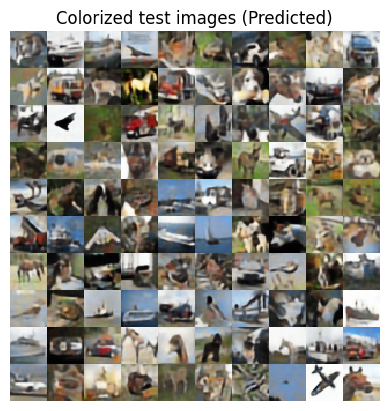

In [17]:
# display the 1st 100 colorized images
imgs = x_decoded[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])

plt.figure()
plt.axis('off')
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/colorized.png' % imgs_dir)
plt.show()

# Variational Autoencoder

## MLP VAE

In [18]:
'''Example of VAE on MNIST dataset using MLP
The VAE has a modular design. The encoder, decoder and VAE
are 3 models that share weights. After training the VAE model,
the encoder can be used to  generate latent vectors.
The decoder can be used to generate MNIST digits by sampling the
latent vector from a Gaussian distribution with mean=0 and std=1.
# Reference
[1] Kingma, Diederik P., and Max Welling.
"Auto-encoding variational bayes."
https://arxiv.org/abs/1312.6114
'''

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os


# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps

def sampling(args):
    """Reparameterization trick by sampling
        fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    # K is the keras backend
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as function
        of 2-dim latent vector
    # Arguments:
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    xmin = ymin = -4
    xmax = ymax = +4
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z, _, _ = encoder.predict(x_test,
                              batch_size=batch_size)
    plt.figure(figsize=(12, 10))

    # axes x and y ranges
    axes = plt.gca()
    axes.set_xlim([xmin,xmax])
    axes.set_ylim([ymin,ymax])

    # subsample to reduce density of points on the plot
    z = z[0::2]
    y_test = y_test[0::2]
    plt.scatter(z[:, 0], z[:, 1], marker="")
    for i, digit in enumerate(y_test):
        axes.annotate(digit, (z[i, 0], z[i, 1]))
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()


# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary
# with the TensorFlow backend
z = Lambda(sampling,
           output_shape=(latent_dim,),
           name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder,
           to_file='vae_mlp_encoder.png',
           show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder,
           to_file='vae_mlp_decoder.png',
           show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    help_ = "Load tf model trained weights"
    parser.add_argument("-w", "--weights", help=help_)
    help_ = "Use binary cross entropy instead of mse (default)"
    parser.add_argument("--bce", help=help_, action='store_true')
    #args = parser.parse_args()
    args = parser.parse_args(args=[])
    models = (encoder, decoder)
    data = (x_test, y_test)

    # VAE loss = mse_loss or xent_loss + kl_loss
    if False: #args.bce:
        reconstruction_loss = binary_crossentropy(inputs,
                                                  outputs)
    else:
        reconstruction_loss = mse(inputs, outputs)

    reconstruction_loss *= original_dim
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')
    vae.summary()

    #plot_model(vae, to_file='vae_mlp.png', show_shapes=True)

    save_dir = "/content/vae_mlp_weights"

    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    if False: #args.weights:
        filepath = os.path.join(save_dir, args.weights)
        vae = vae.load_weights(filepath)
    else:
        # train the autoencoder
        vae.fit(x_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(x_test, None))
        filepath = os.path.join(save_dir, 'vae_mlp_mnist.tf')
        vae.save_weights(filepath)

'''
    plot_results(models,
                 data,
                 batch_size=batch_size,
                 model_name="vae_mlp")
                 '''

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 784)]                0         []                            
                                                                                                  
 dense_8 (Dense)             (None, 512)                  401920    ['encoder_input[0][0]']       
                                                                                                  
 z_mean (Dense)              (None, 2)                    1026      ['dense_8[0][0]']             
                                                                                                  
 z_log_var (Dense)           (None, 2)                    1026      ['dense_8[0][0]']             
                                                                                            

'\n    plot_results(models,\n                 data,\n                 batch_size=batch_size,\n                 model_name="vae_mlp")\n                 '

In [19]:
import matplotlib.pyplot as plt

def plot_latent_distribution(data, labels, encoder):
    """
    Plots the latent distribution of the data using a 2D latent space.

    Parameters:
    - data: The input data to encode and plot.
    - encoder: The encoder model with a `predict` method that encodes data into a 2D latent space.
    """

    # Use the encoder to transform the data into the latent space
    latent_variables, _, _ = encoder.predict(data, batch_size=batch_size)

    # Check if the latent space is 2D
    if latent_variables.shape[1] != 2:
        raise ValueError("The latent space is not 2D.")

    # Plotting the latent space distribution
    plt.figure(figsize=(8, 8))
    plt.scatter(latent_variables[:, 0], latent_variables[:, 1], c = labels, alpha=0.7)
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('Latent Space Distribution')
    plt.grid(True)
    plt.show()

79/79 [==============================] - 0s 2ms/step


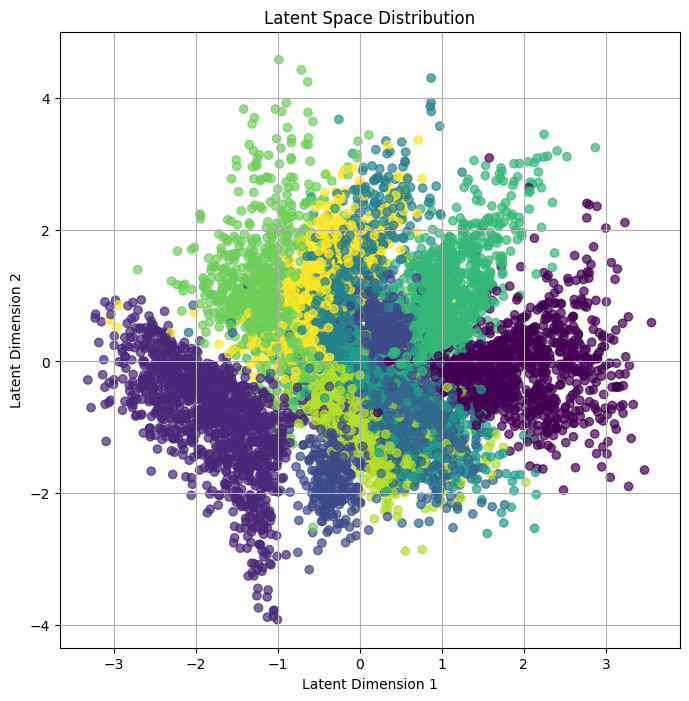

In [20]:
plot_latent_distribution(x_test, y_test, encoder)

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def plot_latent_space(decoder, num_samples=10, grid_range=3, image_size=(28, 28)):
    """
    Generates a grid of images decoded from latent space points.

    Parameters:
    - decoder: The decoder model that decodes latent points into images.
    - num_samples: The number of images per dimension in the grid.
    - grid_range: The range of values in each dimension of the latent space grid.
    - image_size: A tuple (height, width) of the images.
    """

    # Linearly spaced coordinates corresponding to the 2D grid
    grid_x = np.linspace(-grid_range, grid_range, num_samples)
    grid_y = np.linspace(-grid_range, grid_range, num_samples)

    # Create a figure with subplots
    figure, axes = plt.subplots(num_samples, num_samples, figsize=(10, 10))

    # Remove inner axes numbers
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])

    # Plotting the grid
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample);
            img = x_decoded[0].reshape(image_size)  # Adjust the shape based on your data
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].axis('off')

    # Adjust the spacing between plots
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

1/1 [==============================] - 0s 16ms/step


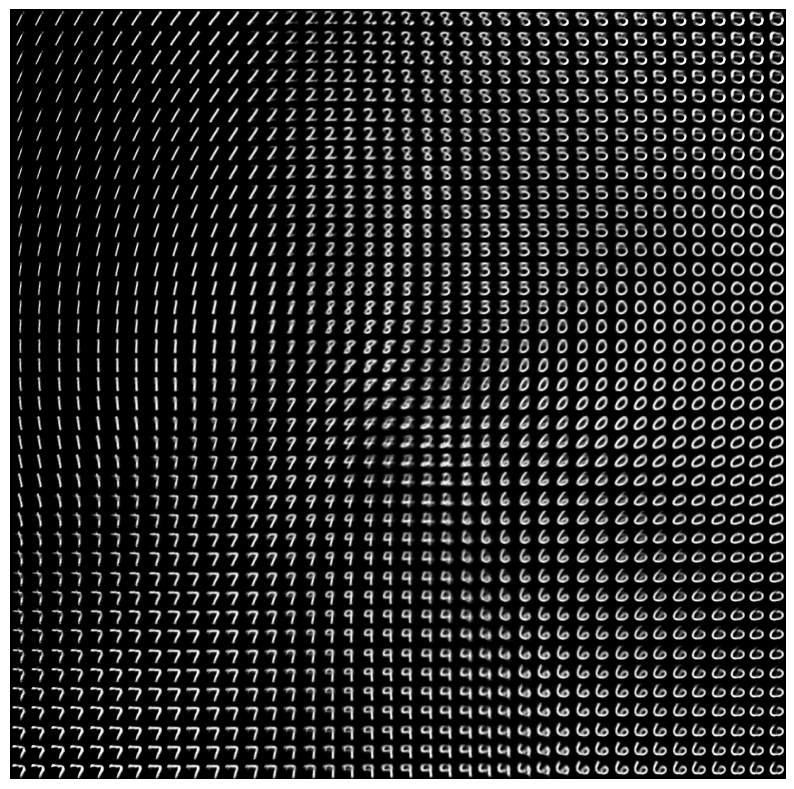

In [22]:
plot_latent_space(decoder, num_samples=40, grid_range=3, image_size=(28, 28))

## DCNN VAE

In [23]:
'''Example of VAE on MNIST dataset using CNN
The VAE has a modular design. The encoder, decoder and VAE
are 3 models that share weights. After training the VAE model,
the encoder can be used to  generate latent vectors.
The decoder can be used to generate MNIST digits by sampling the
latent vector from a Gaussian distribution with mean=0 and std=1.
# Reference
[1] Kingma, Diederik P., and Max Welling.
"Auto-encoding variational bayes."
https://arxiv.org/abs/1312.6114
'''

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten, Lambda
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os


# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling
        fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

'''
x_train = x_train[0::10]
y_train = y_train[0::10]
x_test = x_test[0::10]
y_test = y_test[0::10]
'''

x_train = x_train[y_train == 8]
y_train = y_train[y_train == 8]
x_test = x_test[y_test == 8]
y_test = y_test[y_test == 8]

image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
filters = 16
latent_dim = 2
epochs = 30

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(2):
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary
# with the TensorFlow backend
z = Lambda(sampling,
           output_shape=(latent_dim,),
           name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder,
           to_file='vae_cnn_encoder.png',
           show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3],
          activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(2):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
    filters //= 2

outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder,
           to_file='vae_cnn_decoder.png',
           show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    help_ = "Load tf model trained weights"
    parser.add_argument("-w", "--weights", help=help_)
    help_ = "Use binary cross entropy instead of mse (default)"
    parser.add_argument("--bce", help=help_, action='store_true')
    args = parser.parse_args(args = [])
    models = (encoder, decoder)
    data = (x_test, y_test)

    # VAE loss = mse_loss or xent_loss + kl_loss
    if True: #args.bce:
        reconstruction_loss = binary_crossentropy(K.flatten(inputs),
                                                  K.flatten(outputs))
    else:
        reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))

    reconstruction_loss *= image_size * image_size
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='rmsprop')
    vae.summary()

    #plot_model(vae, to_file='vae_cnn.png', show_shapes=True)

    save_dir = "/content/vae_mlp_weights"
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    if False: #args.weights:
        filepath = os.path.join(save_dir, args.weights)
        vae = vae.load_weights(filepath)
    else:
        # train the autoencoder
        vae.fit(x_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(x_test, None))
        filepath = os.path.join(save_dir, 'vae_cnn_mnist.tf')
        vae.save_weights(filepath)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_10 (Conv2D)          (None, 14, 14, 32)           320       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_11 (Conv2D)          (None, 7, 7, 64)             18496     ['conv2d_10[0][0]']           
                                                                                                  
 flatten_4 (Flatten)         (None, 3136)                 0         ['conv2d_11[0][0]']           
                                                                                            

In [24]:
import matplotlib.pyplot as plt

def plot_latent_distribution(data, labels, encoder):
    """
    Plots the latent distribution of the data using a 2D latent space.

    Parameters:
    - data: The input data to encode and plot.
    - encoder: The encoder model with a `predict` method that encodes data into a 2D latent space.
    """

    # Use the encoder to transform the data into the latent space
    latent_variables, _, _ = encoder.predict(data, batch_size=batch_size)

    # Check if the latent space is 2D
    if latent_variables.shape[1] != 2:
        raise ValueError("The latent space is not 2D.")

    # Plotting the latent space distribution
    plt.figure(figsize=(8, 6))
    plt.scatter(latent_variables[:, 0], latent_variables[:, 1], c = labels, alpha=0.7)
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('Latent Space Distribution')
    plt.grid(True)
    plt.show()

8/8 [==============================] - 0s 2ms/step


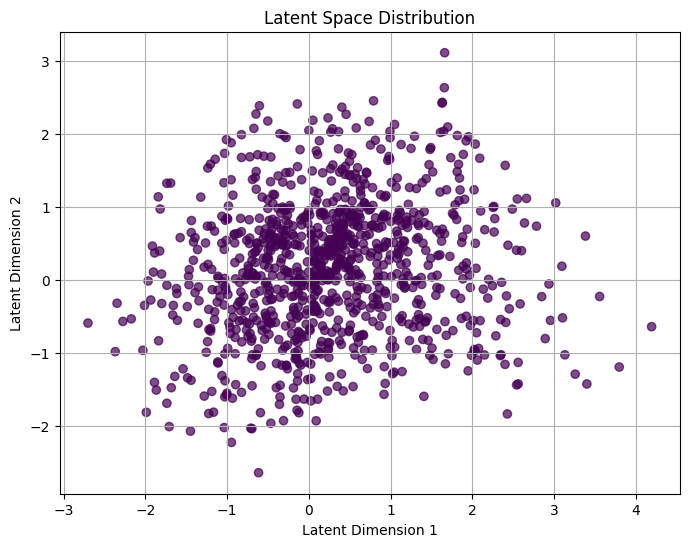

In [25]:
plot_latent_distribution(x_test, y_test, encoder)

In [26]:
import numpy as np
import matplotlib.pyplot as plt

def plot_latent_space(decoder, num_samples=10, grid_range=3, image_size=(28, 28)):
    """
    Generates a grid of images decoded from latent space points.

    Parameters:
    - decoder: The decoder model that decodes latent points into images.
    - num_samples: The number of images per dimension in the grid.
    - grid_range: The range of values in each dimension of the latent space grid.
    - image_size: A tuple (height, width) of the images.
    """

    # Linearly spaced coordinates corresponding to the 2D grid
    grid_x = np.linspace(-grid_range, grid_range, num_samples)
    grid_y = np.linspace(-grid_range, grid_range, num_samples)

    # Create a figure with subplots
    figure, axes = plt.subplots(num_samples, num_samples, figsize=(10, 10))

    # Remove inner axes numbers
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])

    # Plotting the grid
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample);
            img = x_decoded[0].reshape(image_size)  # Adjust the shape based on your data
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].axis('off')

    # Adjust the spacing between plots
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

1/1 [==============================] - 0s 18ms/step


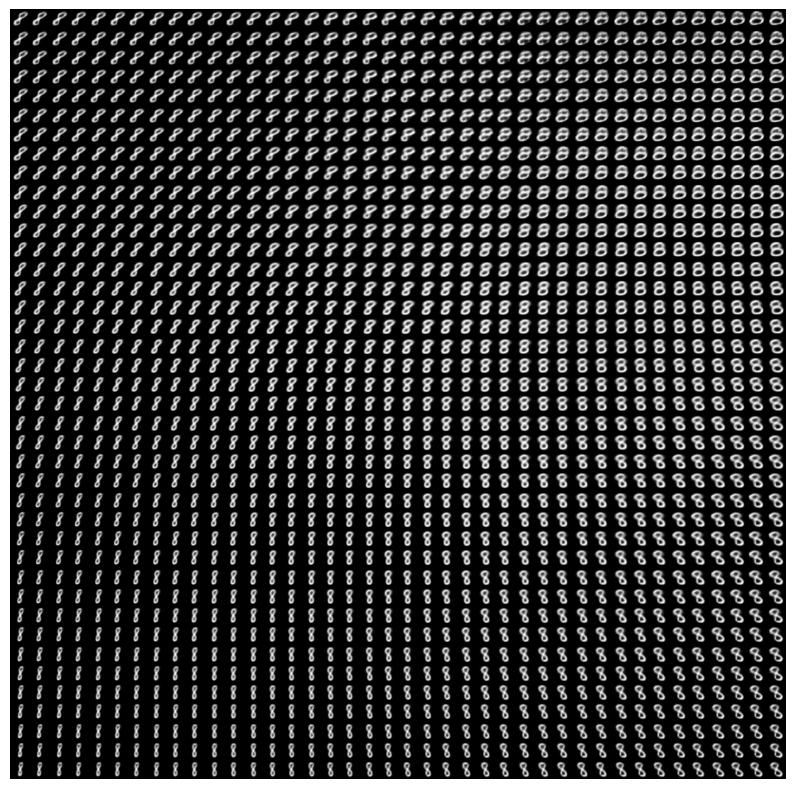

In [27]:
plot_latent_space(decoder, num_samples=40, grid_range=3, image_size=(28, 28))

# Conditional VAE

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 class_labels (InputLayer)   [(None, 10)]                 0         []                            
                                                                                                  
 dense_13 (Dense)            (None, 784)                  8624      ['class_labels[0][0]']        
                                                                                                  
 encoder_input (InputLayer)  [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 reshape_4 (Reshape)         (None, 28, 28, 1)            0         ['dense_13[0][0]']            
                                                                                            

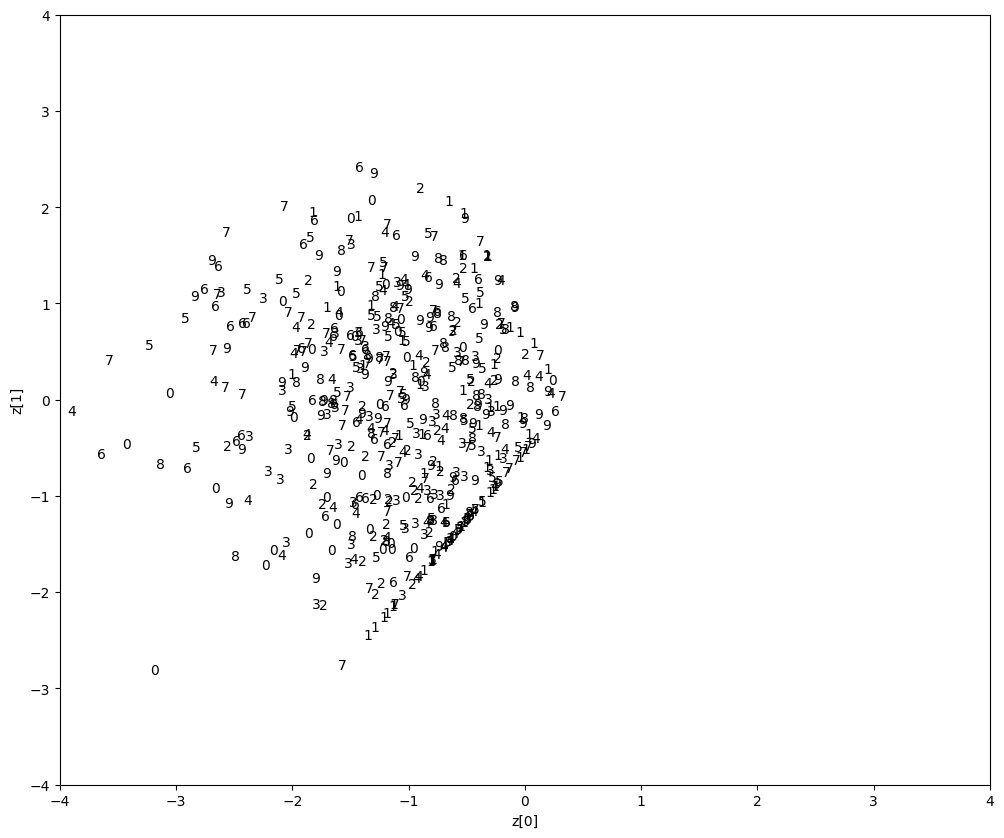

In [28]:
'''Example of CVAE on MNIST dataset using CNN
This VAE has a modular design. The encoder, decoder and vae
are 3 models that share weights. After training vae,
the encoder can be used to  generate latent vectors.
The decoder can be used to generate MNIST digits by sampling the
latent vector from a gaussian dist with mean=0 and std=1.
[1] Sohn, Kihyuk, Honglak Lee, and Xinchen Yan.
"Learning structured output representation using
deep conditional generative models."
Advances in Neural Information Processing Systems. 2015.
'''

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten, Lambda
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Implements reparameterization trick by sampling
    from a gaussian with zero mean and std=1.
    Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    Returns:
        sampled latent vector (tensor)
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def plot_results(models,
                 data,
                 y_label,
                 batch_size=128,
                 model_name="cvae_mnist"):
    """Plots 2-dim mean values of Q(z|X) using labels
        as color gradient then, plot MNIST digits as
        function of 2-dim latent vector
    Arguments:
        models (list): encoder and decoder models
        data (list): test data and label
        y_label (array): one-hot vector of which digit to plot
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    xmin = ymin = -4
    xmax = ymax = +4
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z, _, _ = encoder.predict([x_test, to_categorical(y_test)],
                              batch_size=batch_size)
    plt.figure(figsize=(12, 10))

    # axes x and y ranges
    axes = plt.gca()
    axes.set_xlim([xmin,xmax])
    axes.set_ylim([ymin,ymax])

    # subsample to reduce density of points on the plot
    z = z[0::2]
    y_test = y_test[0::2]
    plt.scatter(z[:, 0], z[:, 1], marker="")
    for i, digit in enumerate(y_test):
        axes.annotate(digit, (z[i, 0], z[i, 1]))
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train[0::10]
y_train = y_train[0::10]
x_test = x_test[0::10]
y_test = y_test[0::10]

image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# compute the number of labels
num_labels = len(np.unique(y_train))

# network parameters
input_shape = (image_size, image_size, 1)
label_shape = (num_labels, )
batch_size = 128
kernel_size = 3
filters = 16
latent_dim = 2
epochs = 30

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
y_labels = Input(shape=label_shape, name='class_labels')
x = Dense(image_size * image_size)(y_labels)
x = Reshape((image_size, image_size, 1))(x)
x = concatenate([inputs, x])
for i in range(2):
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary
# with the TensorFlow backend
z = Lambda(sampling,
           output_shape=(latent_dim,),
           name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model([inputs, y_labels],
                [z_mean, z_log_var, z],
                name='encoder')
encoder.summary()
plot_model(encoder,
           to_file='cvae_cnn_encoder.png',
           show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = concatenate([latent_inputs, y_labels])
x = Dense(shape[1]*shape[2]*shape[3], activation='relu')(x)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(2):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
    filters //= 2

outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model([latent_inputs, y_labels],
                outputs,
                name='decoder')
decoder.summary()
plot_model(decoder,
           to_file='cvae_cnn_decoder.png',
           show_shapes=True)

# instantiate vae model
outputs = decoder([encoder([inputs, y_labels])[2], y_labels])
cvae = Model([inputs, y_labels], outputs, name='cvae')

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    help_ = "Load tf model trained weights"
    parser.add_argument("-w", "--weights", help=help_)
    help_ = "Use binary cross entropy instead of mse (default)"
    parser.add_argument("--bce", help=help_, action='store_true')
    help_ = "Specify a specific digit to generate"
    parser.add_argument("-d", "--digit", type=int, help=help_)
    help_ = "Beta in Beta-CVAE. Beta > 1. Default is 1.0 (CVAE)"
    parser.add_argument("-b", "--beta", type=float, help=help_)
    args = parser.parse_args(args = [])
    models = (encoder, decoder)
    data = (x_test, y_test)

    if True: #args.beta is None or args.beta < 1.0:
        beta = 1.0
        print("CVAE")
        model_name = "cvae_cnn_mnist"
        save_dir = "cvae_weights"
    else:
        beta = args.beta
        print("Beta-CVAE with beta=", beta)
        model_name = "beta-cvae_cnn_mnist"
        save_dir = "beta-cvae_weights"

    # VAE loss = mse_loss or xent_loss + kl_loss
    if True: #args.bce:
        reconstruction_loss = binary_crossentropy(K.flatten(inputs),
                                                  K.flatten(outputs))
    else:
        reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))

    reconstruction_loss *= image_size * image_size
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5 * beta
    cvae_loss = K.mean(reconstruction_loss + kl_loss)
    cvae.add_loss(cvae_loss)
    cvae.compile(optimizer='rmsprop')
    cvae.summary()

    #plot_model(cvae, to_file='cvae_cnn.png', show_shapes=True)

    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    if False: #args.weights:
        filepath = os.path.join(save_dir, args.weights)
        cvae = cvae.load_weights(filepath)
    else:
        cvae.fit([x_train, to_categorical(y_train)],
                 epochs=epochs,
                 batch_size=batch_size,
                 validation_data=([x_test, to_categorical(y_test)], None))
        filename = model_name + '.tf'
        filepath = os.path.join(save_dir, filename)
        cvae.save_weights(filepath)

    #if args.digit in range(0, num_labels):
    #    digit = np.array([args.digit])
    #else:
    #    digit = np.random.randint(0, num_labels, 1)

    digit = 2

    print("CVAE for digit %d" % digit)
    y_label = np.eye(num_labels)[digit]
    label_2 = np.eye(num_labels)[2]  # One-hot encode for digit '2'
    label_2 = np.expand_dims(label_2, axis=0)  # Reshape to match input requirements

    plot_results(models,
                 data,
                 y_label=y_label,
                 batch_size=batch_size,
                 model_name=model_name)

In [29]:
num_labels = 10  # Number of labels in MNIST (digits 0-9)
label_2 = np.eye(num_labels)[6]  # One-hot encode for digit '2'
label_2 = np.expand_dims(label_2, axis=0)  # Reshape to match input requirements

1/1 [==============================] - 0s 107ms/step


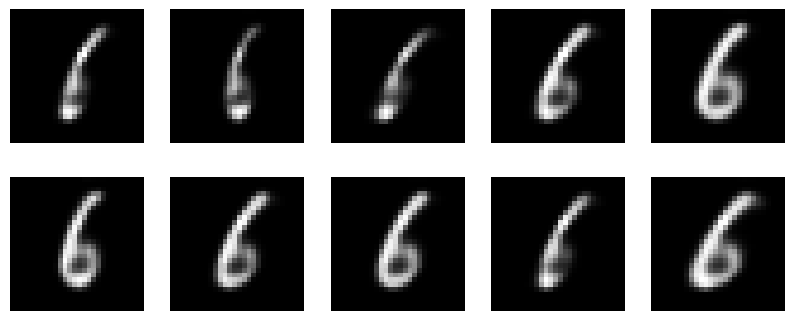

In [30]:
n = 10  # Number of images to generate
digit_size = 28  # Size of MNIST image
latent_dim = 2  # Dimensionality of the latent space

# Sample points from the latent space
np.random.seed(0)  # For reproducibility
latent_samples = np.random.normal(size=(n, latent_dim))

# Generate images from the sampled points and the label
generated_images = decoder.predict([latent_samples, np.tile(label_2, (n, 1))])

# Visualize the generated images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
for i in range(n):
    ax = plt.subplot(2, n // 2, i + 1)
    plt.imshow(generated_images[i].reshape(digit_size, digit_size), cmap='gray')
    plt.axis('off')
plt.show()


1/1 [==============================] - 0s 18ms/step


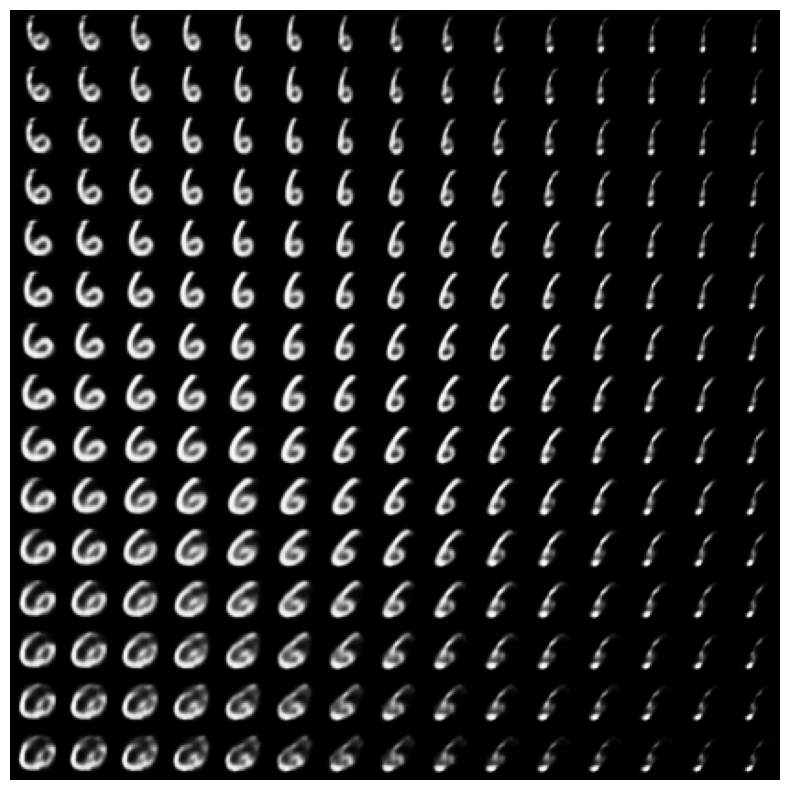

In [31]:
# Define the size of the grid
n = 15  # For a 15x15 grid
grid_x = np.linspace(-3, 3, n)  # Adjust the range as per your latent space distribution
grid_y = np.linspace(-3, 3, n)[::-1]

digit_size = 28  # Size of MNIST image
figure = np.zeros((digit_size * n, digit_size * n))

# Decode for each point in the grid
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict([z_sample, label_2])  # Use the same label for digit '2'
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()